X shape: (8754, 30, 3) y shape: (8754, 3)


c:\Users\sneha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0181 - val_loss: 0.0031
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 5.7915e-04 - val_loss: 8.0092e-04
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 4.6617e-04 - val_loss: 7.8412e-04
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 4.0606e-04 - val_loss: 6.7738e-04
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 3.6040e-04 - val_loss: 6.3493e-04
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 3.4951e-04 - val_loss: 6.1707e-04
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 2.9904e-04 - val_loss: 6.4477e-04
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 2.8687e-04 - val_loss: 6.0418e-04
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 2.9223e-04 - val_loss: 5.6426e-04
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 2.8

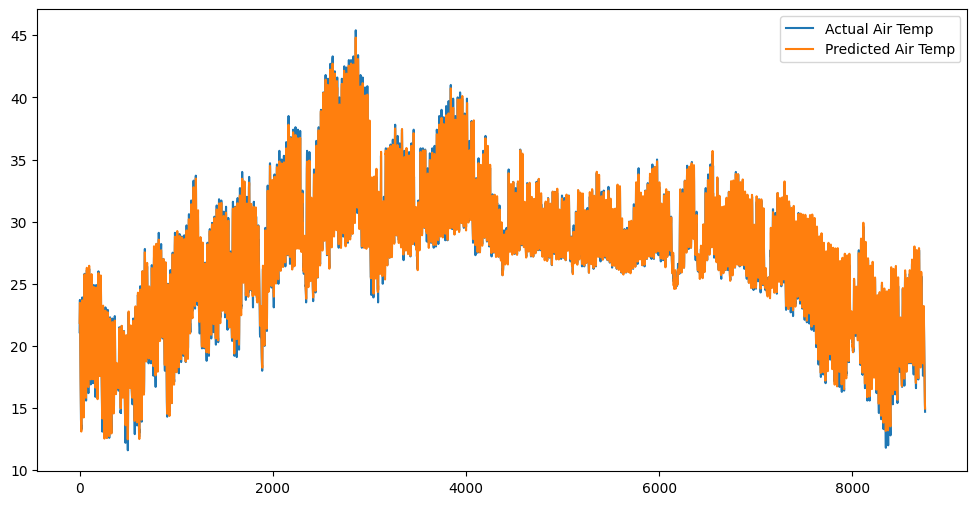

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error , r2_score
import numpy as np

df = pd.read_csv("Kharagpur_weather_data.csv")

# Drop the initial rows which are not part of the actual data
df = df.iloc[2:].copy()
# Set the third row as header
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)

# Keep only required columns
df = df[['time', 'rain (mm)', 'temperature_2m (°C)', 'soil_temperature_18cm (°C)']]

# Convert time column using format='mixed'
df['time'] = pd.to_datetime(df['time'], format='mixed', errors='coerce')
df = df.sort_values('time')

# Convert numerical columns
for col in ['rain (mm)', 'temperature_2m (°C)', 'soil_temperature_18cm (°C)']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values after conversion
df.dropna(inplace=True)


# 2. Preprocess
data = df[['rain (mm)', 'temperature_2m (°C)', 'soil_temperature_18cm (°C)']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(dataset, time_step=30):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step)])
        y.append(dataset[i + time_step])
    return np.array(X), np.array(y)

time_step = 30
X, y = create_sequences(scaled_data, time_step)

# Reshape for LSTM [samples, time steps, features]
print("X shape:", X.shape, "y shape:", y.shape)

# 3. Build LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1]))  # 3 outputs: rainfall, air temp, soil temp

model.compile(optimizer='adam', loss='mse')

# 4. Train
history = model.fit(X, y, batch_size=32, epochs=20, validation_split=0.2)

# 5. Predictions
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Plot Air Temperature actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(df['temperature_2m (°C)'][time_step:].values, label="Actual Air Temp")
plt.plot(predictions[:,1], label="Predicted Air Temp")
plt.legend()
plt.show()

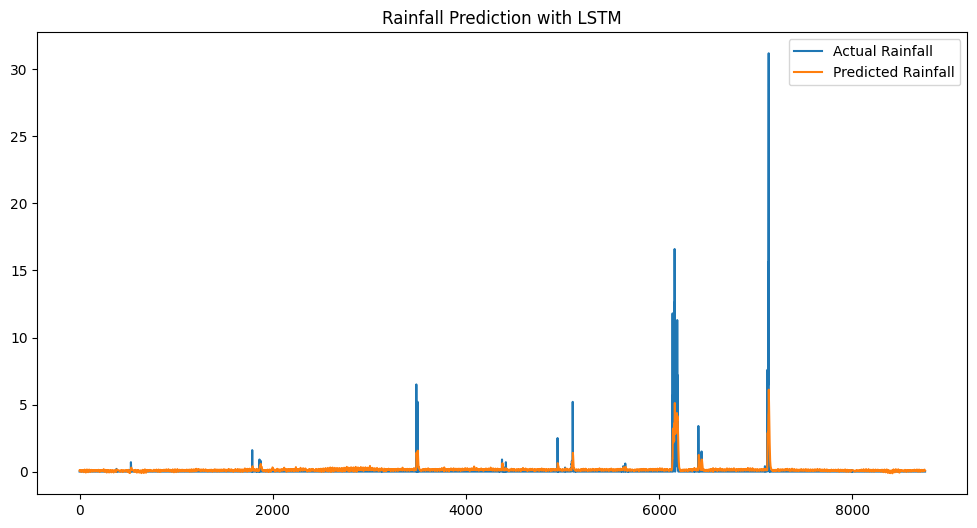

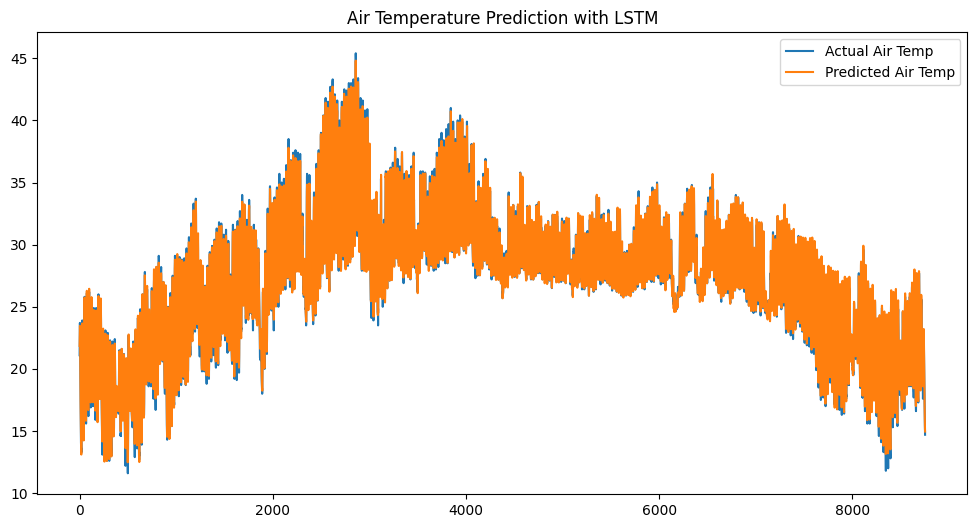

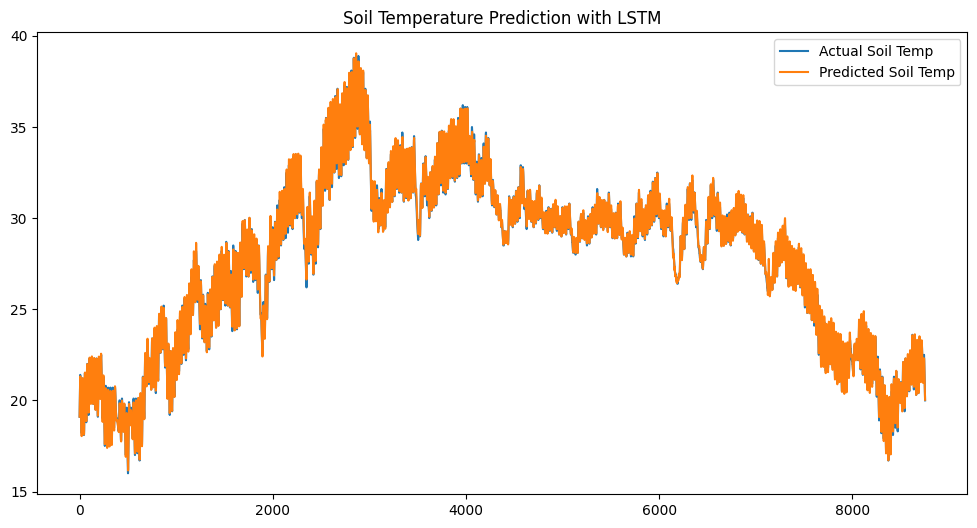

In [2]:
# Plot Rainfall
plt.figure(figsize=(12,6))
plt.plot(df['rain (mm)'][time_step:].values, label="Actual Rainfall")
plt.plot(predictions[:,0], label="Predicted Rainfall")
plt.legend()
plt.title("Rainfall Prediction with LSTM")
plt.show()

# Plot Air Temperature
plt.figure(figsize=(12,6))
plt.plot(df['temperature_2m (°C)'][time_step:].values, label="Actual Air Temp")
plt.plot(predictions[:,1], label="Predicted Air Temp")
plt.legend()
plt.title("Air Temperature Prediction with LSTM")
plt.show()

# Plot Soil Temperature
plt.figure(figsize=(12,6))
plt.plot(df['soil_temperature_18cm (°C)'][time_step:].values, label="Actual Soil Temp")
plt.plot(predictions[:,2], label="Predicted Soil Temp")
plt.legend()
plt.title("Soil Temperature Prediction with LSTM")
plt.show()


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate the model
print("--- Model Evaluation Metrics ---")

# Evaluate Rainfall
mae_rain = mean_absolute_error(df['rain (mm)'][time_step:].values, predictions[:, 0])
mse_rain = mean_squared_error(df['rain (mm)'][time_step:].values, predictions[:, 0])
rmse_rain = np.sqrt(mse_rain)
r2_rain = r2_score(df['rain (mm)'][time_step:].values, predictions[:, 0])
print(f"Rainfall - MAE: {mae_rain:.4f}, MSE: {mse_rain:.4f}, RMSE: {rmse_rain:.4f}, R2: {r2_rain:.4f}")

# Evaluate Air Temperature
mae_temp = mean_absolute_error(df['temperature_2m (°C)'][time_step:].values, predictions[:, 1])
mse_temp = mean_squared_error(df['temperature_2m (°C)'][time_step:].values, predictions[:, 1])
rmse_temp = np.sqrt(mse_temp)
r2_temp = r2_score(df['temperature_2m (°C)'][time_step:].values, predictions[:, 1])
print(f"Air Temperature - MAE: {mae_temp:.4f}, MSE: {mse_temp:.4f}, RMSE: {rmse_temp:.4f}, R2: {r2_temp:.4f}")

# Evaluate Soil Temperature
mae_soil = mean_absolute_error(df['soil_temperature_18cm (°C)'][time_step:].values, predictions[:, 2])
mse_soil = mean_squared_error(df['soil_temperature_18cm (°C)'][time_step:].values, predictions[:, 2])
rmse_soil = np.sqrt(mse_soil)
r2_soil = r2_score(df['soil_temperature_18cm (°C)'][time_step:].values, predictions[:, 2])
print(f"Soil Temperature - MAE: {mae_soil:.4f}, MSE: {mse_soil:.4f}, RMSE: {rmse_soil:.4f}, R2: {r2_soil:.4f}")

print("------------------------------")


--- Model Evaluation Metrics ---
Rainfall - MAE: 0.1681, MSE: 0.3395, RMSE: 0.5827, R2: 0.3162
Air Temperature - MAE: 0.3877, MSE: 0.3013, RMSE: 0.5489, R2: 0.9896
Soil Temperature - MAE: 0.1364, MSE: 0.0314, RMSE: 0.1773, R2: 0.9985
------------------------------


## Saving the model

In [8]:
# Save the model
model.save("../models/weather_lstm_model.h5")
print("Model saved successfully as weather_prediction_model.h5")

Model saved successfully as weather_prediction_model.h5


In [9]:
df.head()

2,time,rain (mm),temperature_2m (°C),soil_temperature_18cm (°C)
0,2024-01-01 00:00:00,0.0,14.2,19.3
1,2024-01-01 01:00:00,0.0,15.1,19.1
2,2024-01-01 02:00:00,0.0,16.7,18.8
3,2024-01-01 03:00:00,0.0,18.6,18.7
4,2024-01-01 04:00:00,0.0,21.1,18.9


In [10]:
df.tail()

2,time,rain (mm),temperature_2m (°C),soil_temperature_18cm (°C)
8779,2024-12-31 19:00:00,0.0,16.1,21.1
8780,2024-12-31 20:00:00,0.0,15.7,20.8
8781,2024-12-31 21:00:00,0.0,15.4,20.5
8782,2024-12-31 22:00:00,0.0,15.1,20.3
8783,2024-12-31 23:00:00,0.0,14.7,20.0
